# SkinAnaliticAI, Skin Cancer Detection with AI Deep Learning

## __Evaluation of Harvard Dataset with different AI classiffication techniques using FastClassAI papeline__
Author: __Pawel Rosikiewicz__   
prosikiewicz@gmail.com      
License: __MIT__    
ttps://opensource.org/licenses/MIT        
Copyright (C) 2021.01.30 Pawel Rosikiewicz        

## Goals:
* quick EDA on data provided by dataset Authors, 
* to prepare a summary table with filtered images (eg no missing data) with all metadata that could be used lateron, in in the project 
* if metadat are not available, you need to find following informaiton on each image:  
    * image names, 
    * original classs label for each image that will correspon dot orinal labels in config files, 

## Key Observations:
* __classed_to_poredict/target__
    * presented in dx column, 
    * 7 classes 
* __columns with dx_type__,   
    * indicates, how the images were classified, From documentarion we know that there were three methods:
    * histo - histopatological, using biopsy to classify the lession - considered most reliable (53.7% of images), 
    * followup - image 
* __missing data__ 
    * approximately 0.1% of rows have missing data  
    * these were found only in one column: age
* __duplicates__
    * all image_id are unique, 
    * howvever, many images are technical duplicates, ie, these are images of the same skin chnages (lesions), taken at different time, angle, magniffication etc.. 

## Caution
* all config files are based on original class labeling, 
* other labelling dictionaries were created to for example, merge different classes easily with each other, 
* if classes are not available, or are "weird", just select one classyficaiton system and then work with it, 
* class labels can be very easily changed, in that project

#### standard imports

In [1]:
import os # allow changing, and navigating files and folders, 
import sys
import shutil
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# setup basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

# set up paths for the project
PATH_raw = os.path.join(basedir, "data/raw")
PATH_interim = os.path.join(basedir, "data/interim")
PATH_interim_dataset_summary_tables = os.path.join(PATH_interim, "dataset_summary_tables") # create in that notebook, 

# caution, loaded only form basedir,
import src.utils.EDA_Helpers2 as eda_helpers 
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.data_preparation_tools import copy_and_organize_files_for_keras_image_generators
from src.utils.data_preparation_tools import create_file_catalogue
from src.utils.data_preparation_tools import create_keras_comptatible_file_subset_with_class_folders
from src.utils.example_plots import *
from src.utils.feature_extraction_tools import encode_images_with_tfhubmodule # with tf.compat.v1 functions, for tf.__version___ >= 1.15
from src.utils.clustered_histogram import find_n_examples_in_each_class, clustered_histogram_with_image_examples, calculate_linkage_for_images_with_extracted_features
from src.utils.clustered_histogram import add_descriptive_notes_to_each_cluster_in_batch_labels, find_clusters_on_dendrogram, create_clustered_heatmap_with_img_examples
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.data_preparation_tools import create_data_subsets

# load project configs
from src.configs.project_configs import PROJECT_NAME
from src.configs.project_configs import CLASS_DESCRIPTION # information on each class, including descriptive class name and diegnostic description - used to help wiht the project
from src.configs.tfhub_configs import TFHUB_MODELS # names of TF hub modules that I presenlected for featuress extraction with all relevant info,
from src.configs.dataset_configs import DATASET_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import CLASS_LABELS_CONFIGS # names created for clases, assigned to original one, and colors assigned to these classes
from src.configs.dataset_configs import DROPOUT_VALUE # str, special value to indicate samples to remoce in class labels

#### variables used to clean the data

In [10]:
DATASET_NAME                      = "HAM10000"  # name used in config files to identify all info on that dataset variant
DATASET_VARIANTS                  = DATASET_CONFIGS[DATASET_NAME]["labels"] # class labels that will be used, SORT_FILES_WITH   must be included
SUMMARY_TABLE_NAME                = f"{DATASET_NAME}_cleaned__dataset_summary_table.csv"

# sorting images into class-labelled folders, 
SORT_FILES_WITH                   = "original_labels" # these class labels will be used to sort images, the other classes will be stored 
INPUT_DATA_DIRNAME_LIST           = ["HAM10000_images_part_1", "HAM10000_images_part_2"] # name of files where are located raw files/images that will be ssegragated with one of the class labe systems
OUTPUT_DIRNAME                    = DATASET_NAME # dir name in basedir/intrim where sorted images will be stored, 


# CREATE DATSET WITH IMAGES/FILES SORTED INTO CLASS-NAMED FOLDERS   
---
* as in part a data preparation this function will:
    * crerate dataset folder in basedir/data/interim
    * there will be at least three folders, test, valid and train datasubsets
* unlike in part a
    * there will be no folders and no validation data, 
    * all images used as train and valid will be in one folder, and the validation subset will be created using keras image generators, 

In [11]:
# Load dataset summary table with all images that will be used
os.chdir(PATH_interim_dataset_summary_tables)
dataset_summary_table = pd.read_csv(SUMMARY_TABLE_NAME)
dataset_summary_table.reset_index(drop=True, inplace=True)
print(dataset_summary_table.shape)

(7418, 14)


## STEP 1. Create dataset variants with class-sorted images - with all available images

### (A) Create dataset variants with class-sorted images
* here you create one folder with all images copied from source data, 
* name duplicazes are removed,
* function copiesd only images present in dataset_summary_table

In [12]:
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing: {dataset_variant}')

    # exctract filenames and original class labels, 
    original_filenames      = pd.Series(dataset_summary_table.loc[:, "original_filenames"])
    original_labels         = pd.Series(dataset_summary_table.loc[:, "original_labels"])
     
    # Find class labels for dataset variant   
    class_labels_variant_dict = CLASS_LABELS_CONFIGS[dataset_variant]["class_labels_dict"]
    new_class_labels = original_labels.map(class_labels_variant_dict)
    
    # Remove dropout class or files, 
    '''here you may add the code, to remove speciffic files/images'''
    idx_to_remove      = np.where(new_class_labels==DROPOUT_VALUE)[0].tolist()
    new_class_labels   = new_class_labels.drop(idx_to_remove).values.tolist()
    original_filenames = original_filenames.drop(idx_to_remove).values.tolist()    
    
    # copy files to temporary directory and organize with new class labels
    _, _ =  copy_and_organize_files_for_keras_image_generators(
            # ... files description
            file_name_list          = original_filenames,   # list, names of files to be copied, if they contain file extension, see ad d nothing below, 
            class_name_list         = new_class_labels,     # list of classses, same lenght as file_names_list, Caution, no special characters allowed !
            # ... inputs
            src_path                = PATH_raw,                 # str, path to file, that holds at least one, specified folder with files (eg images.jpg) to copy, to  data_dst_path/class_name/files eg .jpg
            src_dataset_name_list   = INPUT_DATA_DIRNAME_LIST,  # names of directories, that shodul be found in input_data_path
            # ... outputs
            dst_path                = PATH_interim,        # str, path to file, where the new_dataset file will be created, as follow data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_dataset_name        = f"{DATASET_NAME}__{dataset_variant}",  # str, used to save the file, in data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_subset_name         = "All_files_organized_by_class",    # str, same as above, eg=train data, data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            file_extension_list     = [".jpg"],            # file extensions that shoudl be tranferred, dont forget about the dot., the fucntion will also accept "" as for no extension
            # ...
            verbose=False,
            track_progres=False,  
            return_logfiles=True,                   # returns, list with 
            create_only_logfiles=False              # bool, special option, the function bechaves in the same way, except it do not copy files, but create logfiles only,
                                                    #        with classified, items, grouped in dct where key is a class name, it rtunrs two logfiles, with present and mising files,
        ) 

    # test if the images were copied as expected
    _ = create_file_catalogue(
            path = os.path.join(PATH_interim, 
                                f"{DATASET_NAME}__{dataset_variant}",
                                "All_files_organized_by_class"
                               ),
            searched_class_name_list = None, # if none, catalog, all, 
            verbose=True)
    print(f"\n")

- 0 - Preparing: Cancer_Detection_And_Classification
Basal_cell_carcinoma: 327
Squamous_cell_carcinoma: 228
Melanoma: 613
Melanocytic_nevus: 5361
Benign_keratosis: 718
Vascular_skin_lesions: 98
Dermatofibroma: 73


- 1 - Preparing: Cancer_Risk_Groups
High-melanoma: 613
Medium-benign_cancer: 1346
Low-skin_lession: 5459




### (B) CREATE TEST AND TRAIN DATASET SUBSETS
* in this step we only wish to remove images that were selected to test subsets
* because I separated them as first a) data preparation, i will do it again, in the same order with the same order,  

In [13]:
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing subsets for {dataset_variant}')

    # names,
    src_path                 = os.path.join(PATH_interim, f'{DATASET_NAME}__{dataset_variant}')
    src_subset_name          = f"All_files_organized_by_class"
    dst_path                 = src_path
    new_data_subset_names    = [    'test_01', 'test_02',
                                    'trainvalid_all_cnn']
    file_proportions         = [0.05,0.05]+[0.99] # the last one is larger to ensure that all files will be tranferred and none left due to rounding errors,                  
        
    # create subsets with equal proportins of images from each class
    create_data_subsets(
                src_path                 = src_path,
                src_subset_name          = src_subset_name,
                dst_path                 = dst_path,
                dst_subset_name_list     = new_data_subset_names,
                # ...
                new_subset_size          = file_proportions, # list, ==len(dst_subset_name_list)
                min_new_subset_size      = 0.025,
                # ...
                move_files               = True,
                random_state_nr          = 0,
                fix_random_nr            = True,
                verbose                  = False
            )            
    print("done ........................ no more files to transfer\n")

- 0 - Preparing subsets for Cancer_Detection_And_Classification
Found 7418 images belonging to 7 classes.
Found 7051 images belonging to 7 classes.
Found 6684 images belonging to 7 classes.
done ........................ no more files to transfer

- 1 - Preparing subsets for Cancer_Risk_Groups
Found 7418 images belonging to 3 classes.
Found 7049 images belonging to 3 classes.
Found 6679 images belonging to 3 classes.
done ........................ no more files to transfer



## STEP 2. Create dataset variants with class-sorted images - with all available images

### (A) Create dataset variants with class-sorted images
* here you create one folder with all images copied from source data, 
* name duplicazes are removed,
* function copiesd only images present in dataset_summary_table

In [14]:
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing: {dataset_variant}')

    # exctract filenames and original class labels, 
    original_filenames      = pd.Series(dataset_summary_table.loc[:, "original_filenames"])
    original_labels         = pd.Series(dataset_summary_table.loc[:, "original_labels"])
     
    # Find class labels for dataset variant   
    class_labels_variant_dict = CLASS_LABELS_CONFIGS[dataset_variant]["class_labels_dict"]
    new_class_labels = original_labels.map(class_labels_variant_dict)
    
    # Remove dropout class or files, 
    '''here you may add the code, to remove speciffic files/images'''
    idx_to_remove      = np.where(new_class_labels==DROPOUT_VALUE)[0].tolist()
    new_class_labels   = new_class_labels.drop(idx_to_remove).values.tolist()
    original_filenames = original_filenames.drop(idx_to_remove).values.tolist()    
    
    # copy files to temporary directory and organize with new class labels
    _, _ =  copy_and_organize_files_for_keras_image_generators(
            # ... files description
            file_name_list          = original_filenames,   # list, names of files to be copied, if they contain file extension, see ad d nothing below, 
            class_name_list         = new_class_labels,     # list of classses, same lenght as file_names_list, Caution, no special characters allowed !
            # ... inputs
            src_path                = PATH_raw,                 # str, path to file, that holds at least one, specified folder with files (eg images.jpg) to copy, to  data_dst_path/class_name/files eg .jpg
            src_dataset_name_list   = INPUT_DATA_DIRNAME_LIST,  # names of directories, that shodul be found in input_data_path
            # ... outputs
            dst_path                = PATH_interim,        # str, path to file, where the new_dataset file will be created, as follow data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_dataset_name        = f"{DATASET_NAME}__{dataset_variant}",  # str, used to save the file, in data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            dst_subset_name         = "All_files_organized_by_class",    # str, same as above, eg=train data, data_dst_path/dataset_name/subset_name/class_name/files eg .jpg
            file_extension_list     = [".jpg"],            # file extensions that shoudl be tranferred, dont forget about the dot., the fucntion will also accept "" as for no extension
            # ...
            verbose=False,
            track_progres=False,  
            return_logfiles=True,                   # returns, list with 
            create_only_logfiles=False              # bool, special option, the function bechaves in the same way, except it do not copy files, but create logfiles only,
                                                    #        with classified, items, grouped in dct where key is a class name, it rtunrs two logfiles, with present and mising files,
        ) 

    # test if the images were copied as expected
    _ = create_file_catalogue(
            path = os.path.join(PATH_interim, 
                                f"{DATASET_NAME}__{dataset_variant}",
                                "All_files_organized_by_class"
                               ),
            searched_class_name_list = None, # if none, catalog, all, 
            verbose=True)
    print(f"\n")

- 0 - Preparing: Cancer_Detection_And_Classification
Basal_cell_carcinoma: 327
Squamous_cell_carcinoma: 228
Melanoma: 613
Melanocytic_nevus: 5361
Benign_keratosis: 718
Vascular_skin_lesions: 98
Dermatofibroma: 73


- 1 - Preparing: Cancer_Risk_Groups
High-melanoma: 613
Medium-benign_cancer: 1346
Low-skin_lession: 5459




### (B) CREATE TEST AND TRAIN DATASET SUBSETS
* in this step we only wish to remove images that were selected to test subsets
* because I separated them as first a) data preparation, i will do it again, in the same order with the same order,  

In [15]:
for dt_i, dataset_variant in enumerate(DATASET_VARIANTS):
    print(f'- {dt_i} - Preparing subsets for {dataset_variant}')

    # names,
    src_path                 = os.path.join(PATH_interim, f'{DATASET_NAME}__{dataset_variant}')
    src_subset_name          = f"All_files_organized_by_class"
    dst_path                 = src_path
    new_data_subset_names    = [    'test_01', 'test_02',  # shodul always be the same 
                                    'trainvalid_small_cnn', # it will be used in the first cycle to train the models,
                                    'trainvalid_to_remove'] # this will be removed, 
    file_proportions         = [0.05,0.05]+[0.2]+[0.99] # the last one is larger to ensure that all files will be tranferred and none left due to rounding errors,                  
        
    # create subsets with equal proportins of images from each class
    create_data_subsets(
                src_path                 = src_path,
                src_subset_name          = src_subset_name,
                dst_path                 = dst_path,
                dst_subset_name_list     = new_data_subset_names,
                # ...
                new_subset_size          = file_proportions, # list, ==len(dst_subset_name_list)
                min_new_subset_size      = 0.025,
                # ...
                move_files               = True,
                random_state_nr          = 0,
                fix_random_nr            = True,
                verbose                  = False
            )            
    print("done ........................ no more files to transfer\n")

- 0 - Preparing subsets for Cancer_Detection_And_Classification
Found 7418 images belonging to 7 classes.
Found 7051 images belonging to 7 classes.
Found 6684 images belonging to 7 classes.
Found 5202 images belonging to 7 classes.
done ........................ no more files to transfer

- 1 - Preparing subsets for Cancer_Risk_Groups
Found 7418 images belonging to 3 classes.
Found 7049 images belonging to 3 classes.
Found 6679 images belonging to 3 classes.
Found 5196 images belonging to 3 classes.
done ........................ no more files to transfer



## Check how many images and from what class were placed in each subset in each dtataset variant

* important!
    * you shodul have the same number of images in test01 and test02 images in each dataset varinat as you had before, in notebook 02, a data preparation,  

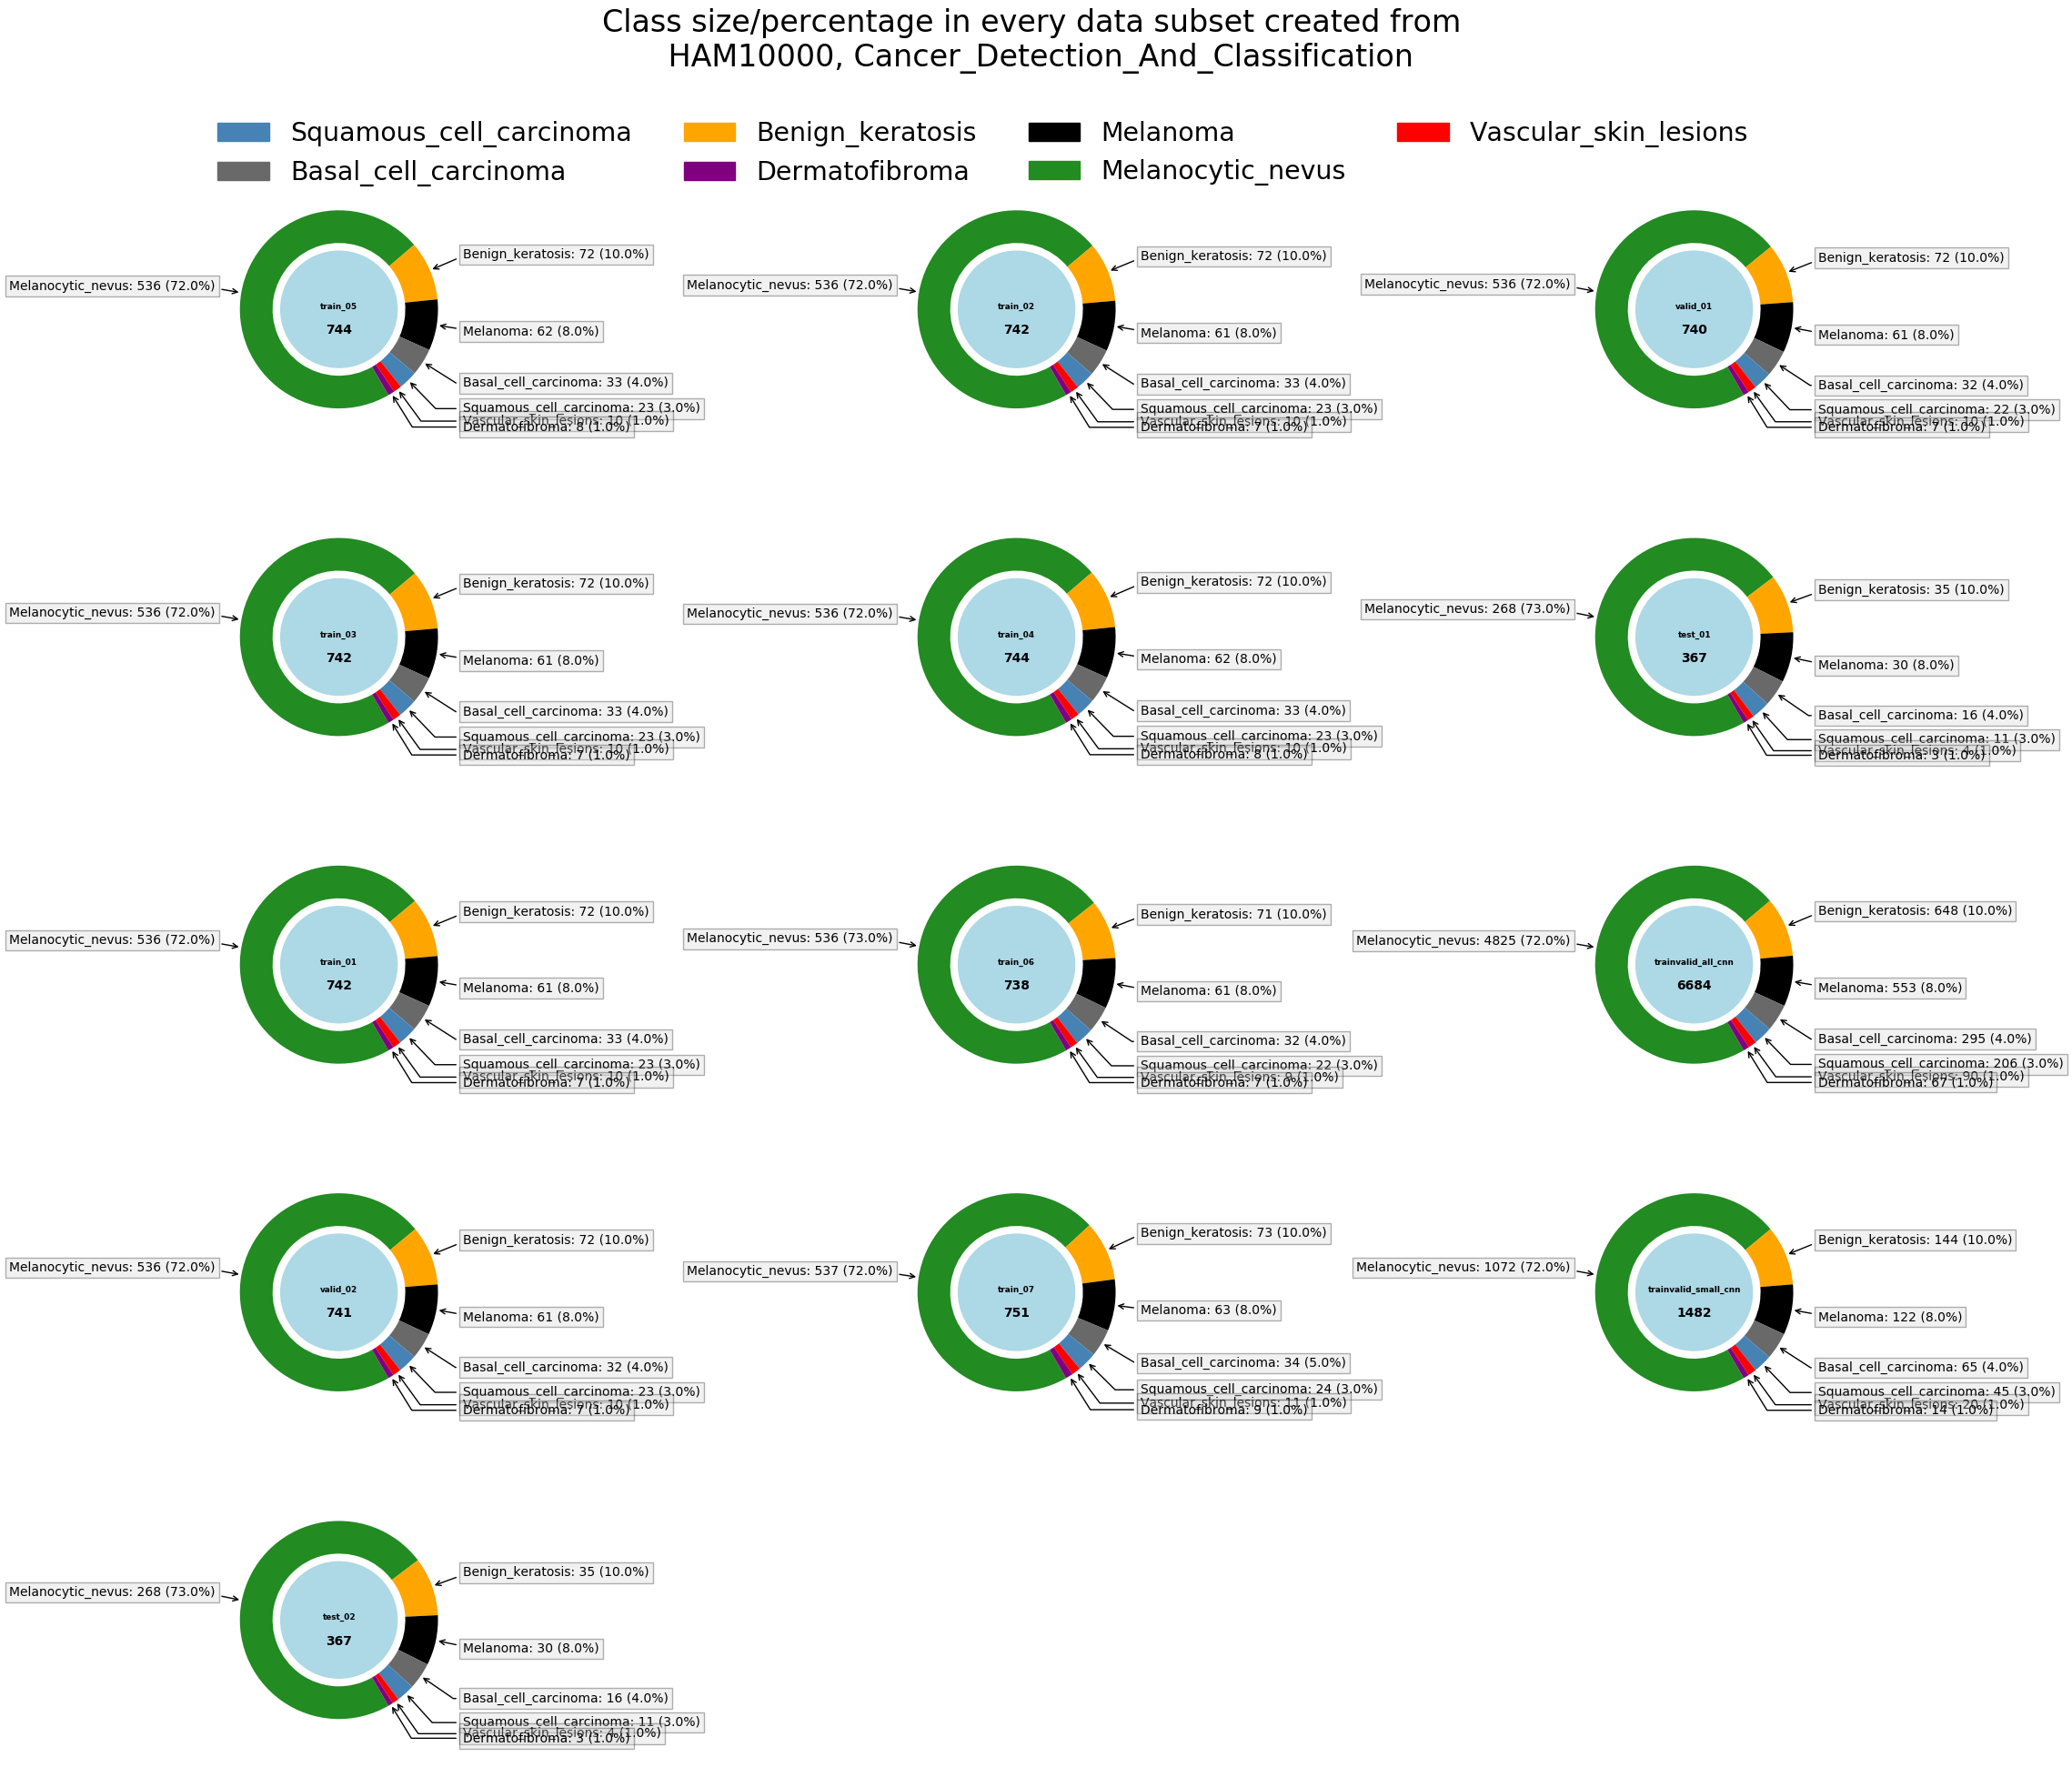

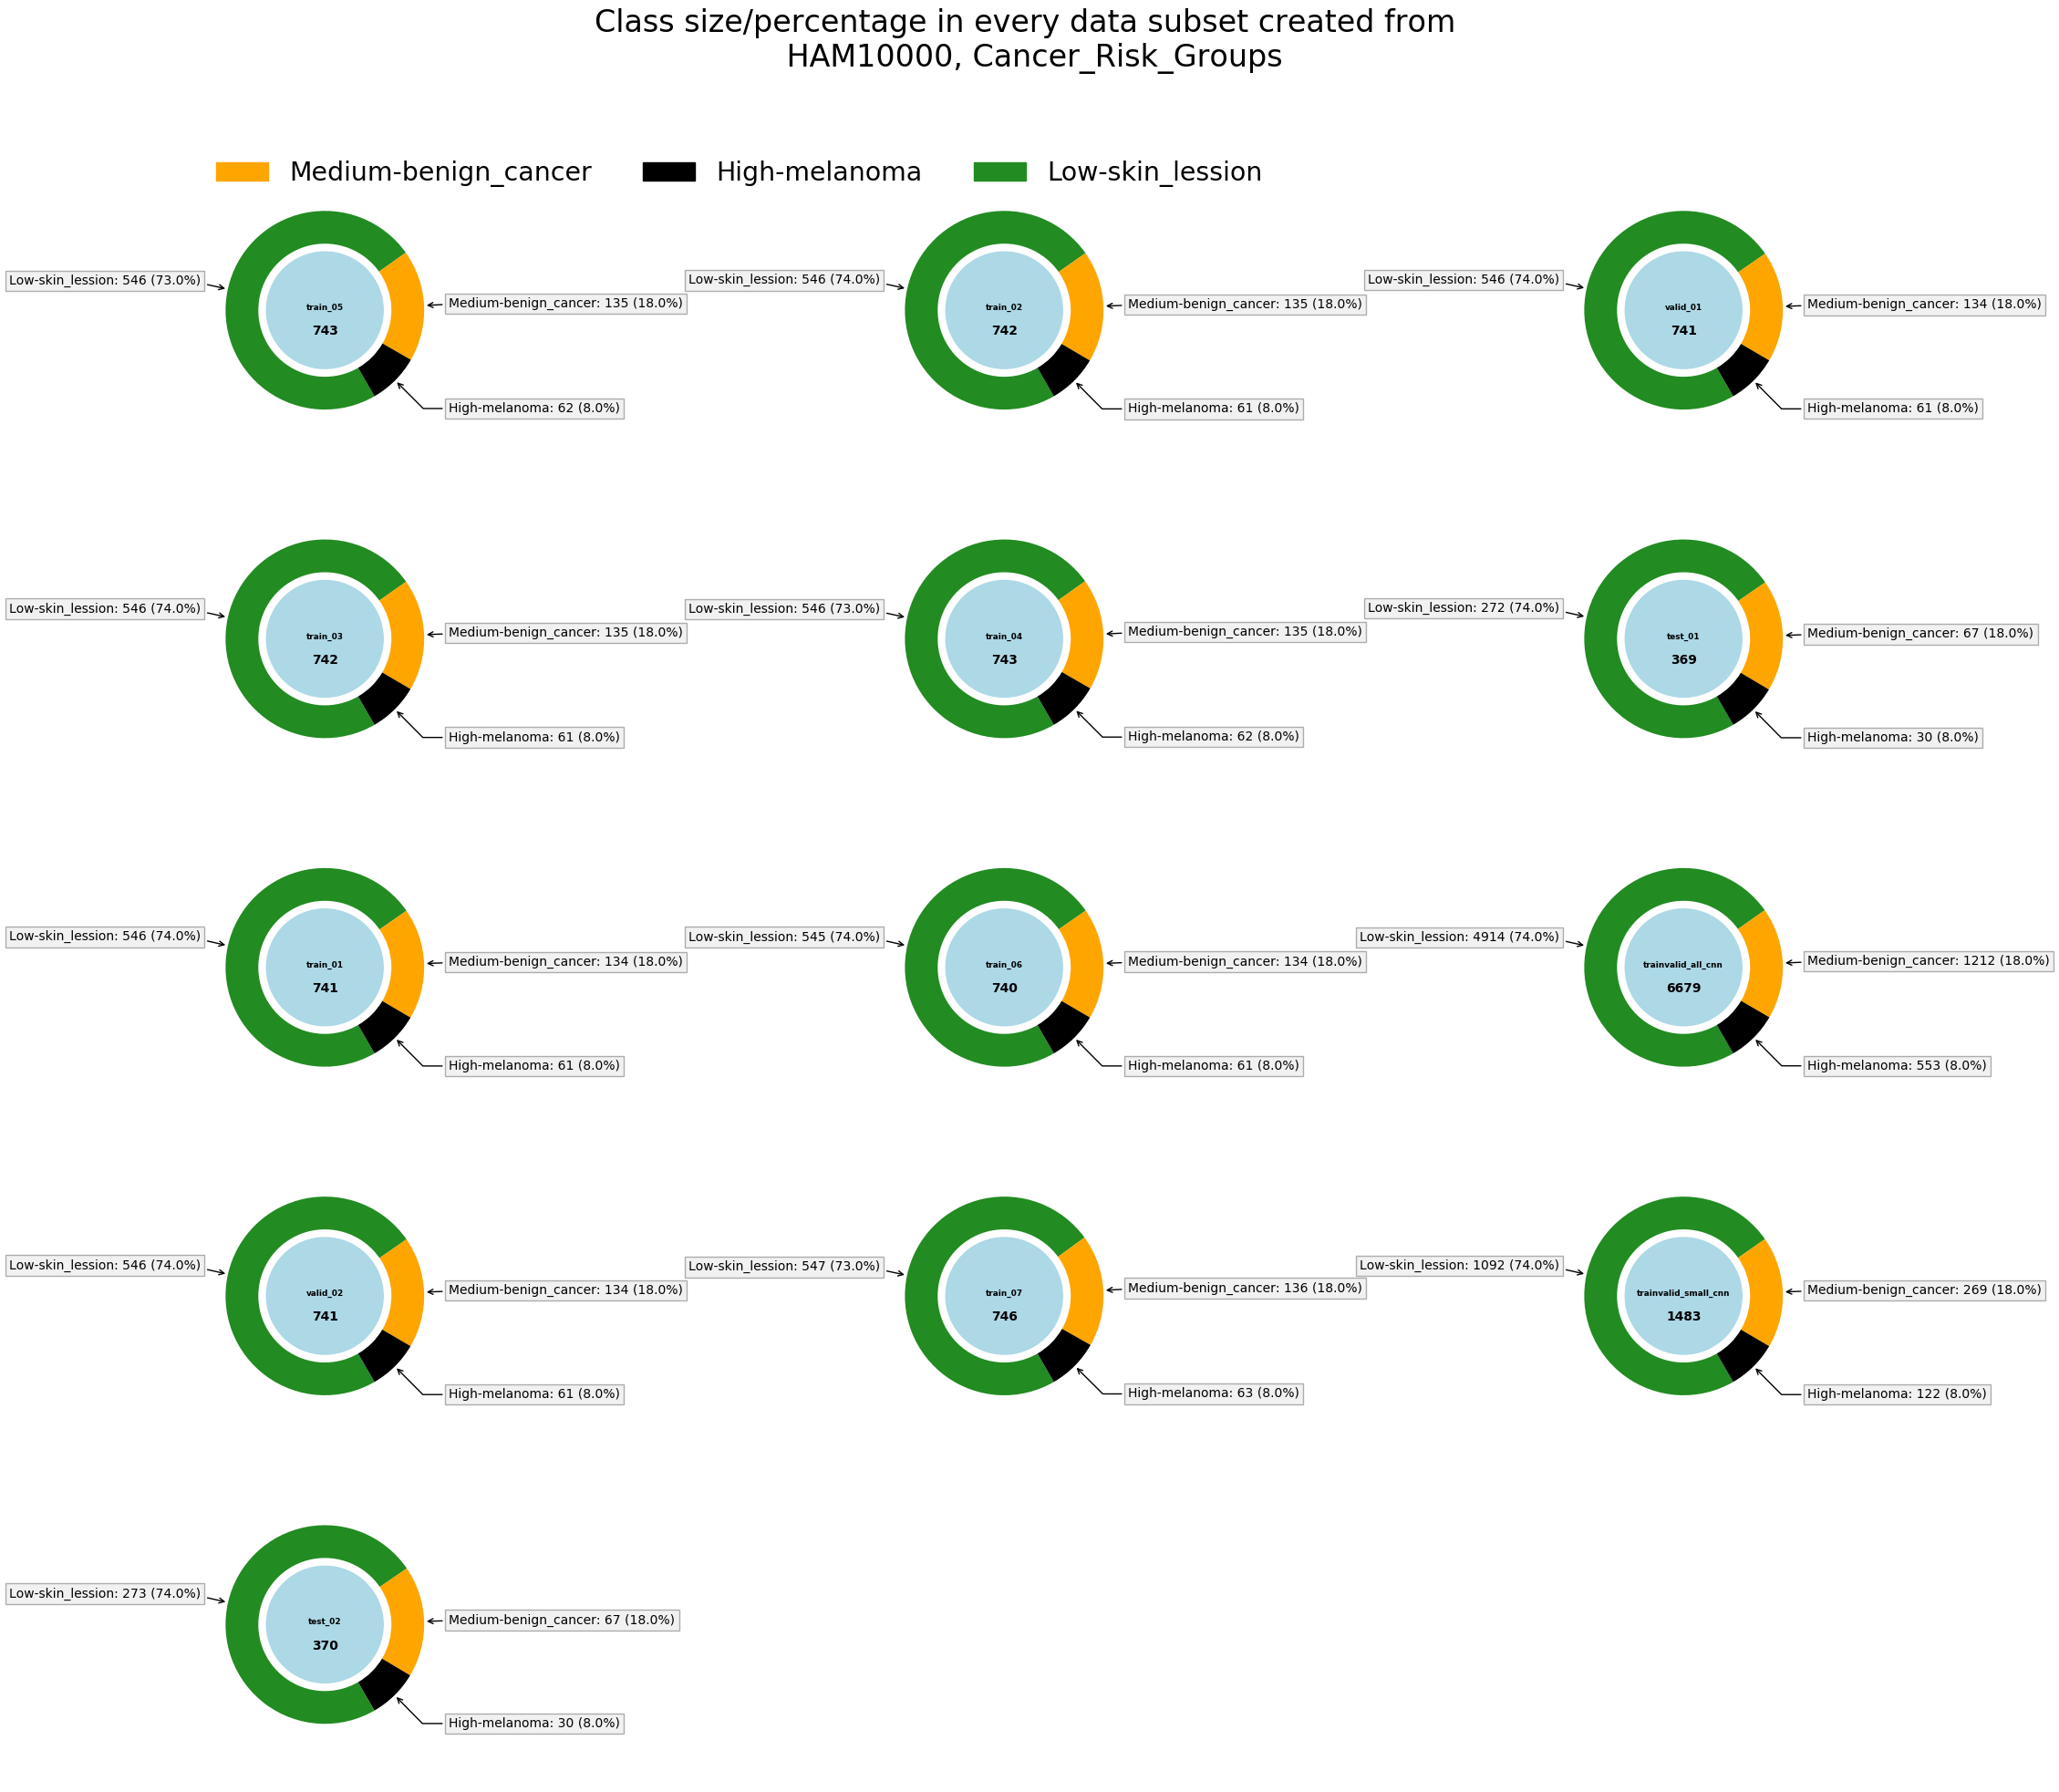

In [16]:
# find all newly created folders wiht subsets in dataset folder, 
for dataset_variant in DATASET_VARIANTS:
    path = os.path.join(PATH_interim, f"{DATASET_NAME}__{dataset_variant}")
    os.chdir(path)
    
    filenames = []
    class_long_list = list()
    file_long_list = list()
    for file in glob.glob(f"[test|valid|train]*"):
        filenames.append(file)    
    
    for s_name in filenames:
        log = create_file_catalogue(
                path = os.path.join(path, s_name),
                searched_class_name_list = None, # if none, catalog, all, 
                verbose=False)
        
        for one_key in list(log.keys()):
            class_long_list.extend([one_key]*len(log[one_key]))
            file_long_list.extend([s_name]*len(log[one_key]))

    # .. Pie chart with dataset composition
    annotated_pie_chart_with_class_and_group(
        title=f'Class size/percentage in every data subset created from \n {DATASET_NAME}, {dataset_variant}',
        classnames=class_long_list,
        groupnames=file_long_list,
        class_colors=CLASS_LABELS_CONFIGS[dataset_variant]["class_labels_colors"], 
        figsze_scale=1.5,
        ax_title_fonsize_scale=0.4,
        wedges_fontsize_scale=1,
        add_group_item_perc_to_numbers_in_each_pie=False,

        title_ha="center",
        mid_pie_circle_color="lightblue",
        tight_lyout=True,
        subplots_adjust_top=0.9,
        legend_loc=(0.1, 0.89),
        legend=True, # because each class is annotated, 
        legend_ncol=4,
        legend_fontsize_scale=4,

        n_subplots_in_row=3
    )

## Show examples of images from different clasees form different subsets in each dataset variant 


 - Cancer_Detection_And_Classification - 

Found 744 images belonging to 7 classes.
train_05, Classes: ['Basal_cell_carcinoma', 'Benign_keratosis', 'Dermatofibroma', 'Melanocytic_nevus', 'Melanoma', 'Squamous_cell_carcinoma', 'Vascular_skin_lesions']


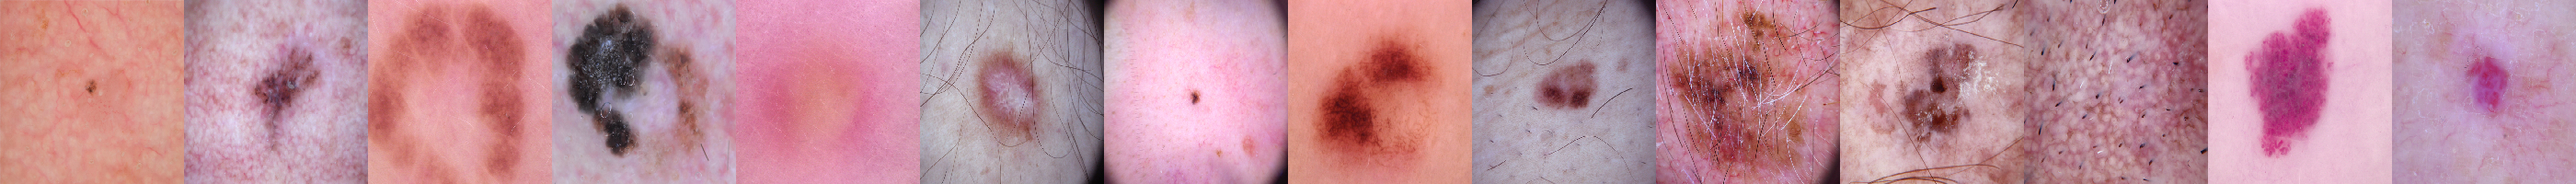


 - Cancer_Risk_Groups - 

Found 743 images belonging to 3 classes.
train_05, Classes: ['High-melanoma', 'Low-skin_lession', 'Medium-benign_cancer']


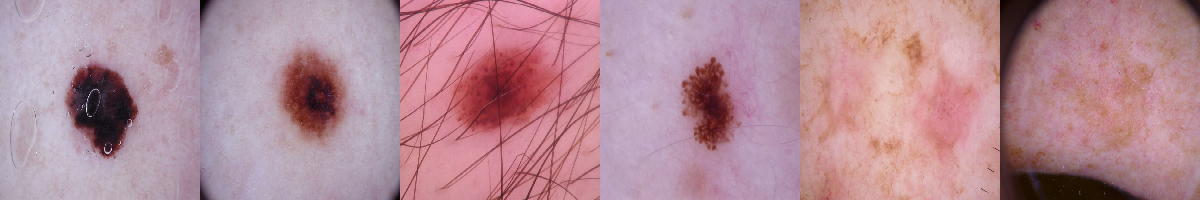

In [17]:
# find all newly created folders wiht subsets in dataset folder, 
for dataset_variant in DATASET_VARIANTS:
    print(f"\n - {dataset_variant} - \n")
    path = os.path.join(PATH_interim, f"{DATASET_NAME}__{dataset_variant}")
    os.chdir(path)
    
    # find filenames with images
    filenames = []
    for file in glob.glob(f"[test|valid|train]*"):
        filenames.append(file)   
        
    # reduce number if dataset to display (too much space)
    filenames = filenames[0:1]    
         
    # create data generator with batch size for up to 1000 randomly selceted images
    datagen = ImageDataGenerator()#rescale=1/255) 
    dataiter_dict = dict()
    for sn in filenames:
        # .. create proper iterator, that allowss loading all availble images, - here it will always load all files, 
        dataiter_dict[sn]  = datagen.flow_from_directory(
                            os.path.join(path, sn), 
                            target_size=(200, 200),
                            batch_size=200, #img_nr_in_one_subset, 
                            shuffle=True # done later on by my fucntion        
        )    


    # Plot two examples of each class from each dataset, 
    for setname in filenames:
        display(plot_example_images_using_generator(
            dataiter_dict[setname],
            title=setname, 
            pixel_size=200, # only one value, as both heigh and width will be the same
            class_n_examples=2)
               )